In [1]:
import cv2
import matplotlib.pyplot as plt 
import numpy as np 
from PIL import Image
from ultralytics import YOLO
import torch.nn as nn
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation

/home/rimsha/Desktop/360 projects/image-computer-vision/image-computer-vision-python/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load a model
model = YOLO('model/yolov8n.pt')  # load an official model

processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model_cloth = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")
label_map_cloth = {0: "Background", 1: "Hat", 2: "Hair", 3: "Sunglasses", 4: "Upper-clothes", 5: "Skirt", 6: "Pants", 7: "Dress", 8: "Belt", 9: "Left-shoe", 10: "Right-shoe", 11: "Face", 12: "Left-leg", 13: "Right-leg", 14: "Left-arm", 15: "Right-arm", 16: "Bag", 17: "Scarf"}

### Pose estimation COCO
protoFile = "model/pose/coco/pose_deploy_linevec.prototxt"
weightsFile = "model/pose/coco/pose_iter_440000.caffemodel"
nPoints = 18
POSE_PAIRS = [[1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

# # Read the network into Memory 
net = cv2.dnn.readNetFromCaffe(protoFile , weightsFile) 


/home/rimsha/Desktop/360 projects/image-computer-vision/image-computer-vision-python/env/lib/python3.11/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


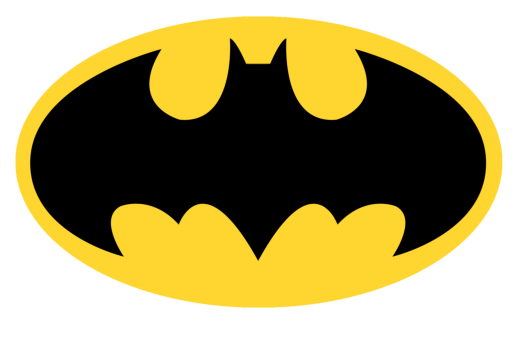

In [13]:


logo = cv2.imread('images/logo.png')
logo = cv2.cvtColor(logo, cv2.COLOR_BGR2RGB)
plt.imshow(logo)
plt.axis('off')
plt.show()

In [7]:
def modify_logo_size(logo_copy, w, h, scale=0.03): 
    '''modifies the size of the original logo based on image on which to place it, 
    whose width and height is w, h'''
    if h < w: 
        w = h 
    hlogo, wlogo = int(scale*w), int(scale*w)
    logo_copy = cv2.resize(logo_copy, 
                           (hlogo, wlogo), 
                           interpolation = cv2.INTER_LINEAR)
    return logo_copy

def find_logo_placement(shirt): 
    
    '''
    Figure out where to place the logo in a given image. 
    This is empirical and can be changed based on preference of user. 
    '''
    
    heights, widths = np.shape(shirt)
    ratio = heights/widths 
        
    if ratio > 0.8: 
        lefthalf = (widths / 2)
        lefthalf = lefthalf + (lefthalf/3)*ratio
        topfourth = heights / 4 
    else: 
        lefthalf = (widths / 2)
        lefthalf = lefthalf + (lefthalf/5.5)/ratio
        topfourth = heights / 4 / ratio
        
    return int(lefthalf), int(topfourth)

def find_logo_placement_pose(pose_information):
    
    '''
    Finds the shift in logo placement in accordance to the person's pose'''
    
    leftsx, leftsy = pose_information[0][1:]
    rightsx, rightsy = pose_information[1][1:]

    shoulder_width = rightsx - leftsx
    halfwayx = np.mean([leftsx, rightsx])
    lefthalf = halfwayx + shoulder_width // 4
    
    topfourth = rightsy + 10 
    
    return int(lefthalf), int(topfourth)

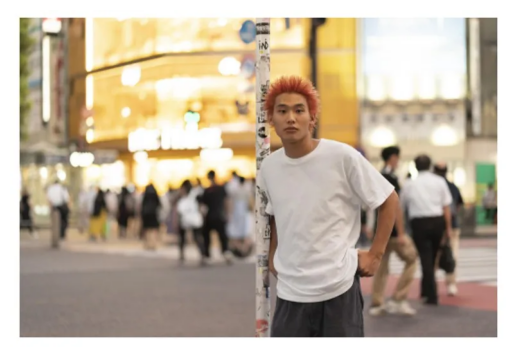

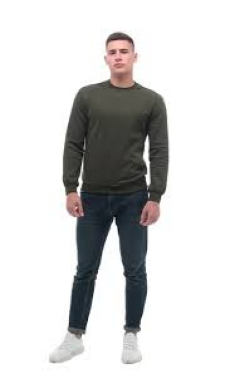

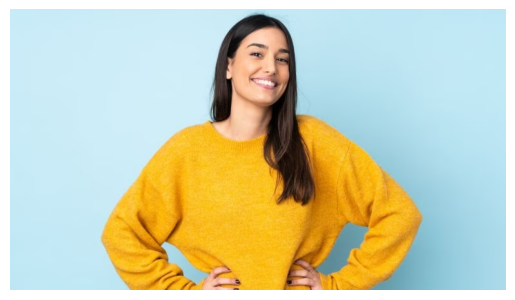

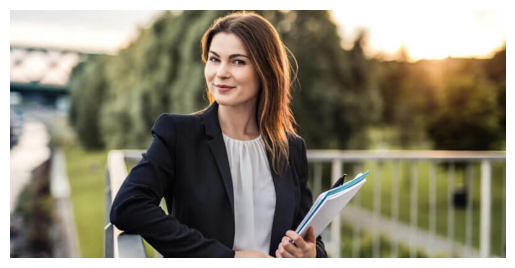

In [14]:
for _ in range(1, 5):
    image_name = f'images/person{_}.png'
    image = cv2.imread(image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ### Show input image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [15]:
def perform_logo_placement(image_name):
    
    ''' 
    Given image file name, 
    1. Run yolov8 to detect people in the image
    2. Find the foreground person, since there can be multiple
    3. Detect shirt using mattmdjaga/segformer_b2_clothes (segmentation for garments)
    4. Pose estimation for the foreground person
    5. Use shoulders detected from pose estimation to get the location where logo must be placed
    6. Add the logo to the original image. 
    '''
    
    ### Read image
    image = cv2.imread(image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ### Show input image
    plt.imshow(image)
    plt.title('Input image')
    plt.axis('off')
    plt.show()
    
    ## Run YOLO on image to detect person
    results = model(image_name)  # predict on an image

    for idx, result in enumerate(results):
        
        boxes = result.boxes  # Boxes object for bounding box outputs
        names = result.names  # label map 
        
        ### To find the foreground person
        boxes_person = []
        
        for b in boxes: 

            bcls = int(b.cls.numpy()[0])
            label = names[bcls]
            if label != 'person': 
                continue 
            
            ### .conf gives us the probablity of detection
            bconf = b.conf.numpy()[0]
            x,y,w,h = b.xyxy.numpy()[0]
            
            boxes_person.append([bconf, x, y, w, h])
            
        boxes_person = np.array(boxes_person)
        max_index = np.argmax(boxes_person[:, 0])
        
        ## find the person with max prob/foreground person
        foreground_person = boxes_person[max_index].astype(int)
        x,y,w,h = foreground_person[1: ]   
            
        roi = image[y:y+h, x:w]
        
        ### Show foreground person detection boundaries
        plt.imshow(roi)
        plt.title('Detection of the foreground person')
        plt.axis('off')
        plt.show()

        ## detect clothes in the foreground person 
        inputs = processor(images=roi, return_tensors="pt")
        outputs = model_cloth(**inputs)
        logits = outputs.logits.cpu()
        logits = logits.detach().squeeze(0).numpy()
        logits = logits.argmax(axis=0).astype(float)
        logits = cv2.resize(logits, (roi.shape[1], 
                                     roi.shape[0]), 
                            interpolation = cv2.INTER_LINEAR)

        upper_clothes = logits.copy()
        
        ### 4 is the index for upper clothes (t-shirt)
        upper_clothes[upper_clothes!=4] = 0 
        
        xc, yc = np.where(upper_clothes == 4)
        xminc, xmaxc = np.min(xc), np.max(xc)
        yminc, ymaxc = np.min(yc), np.max(yc)
        
        shirt = upper_clothes[xminc:xmaxc, yminc:ymaxc]
        height_shirt = xmaxc-xminc
        width_shirt = ymaxc-yminc
        
        logo_copy = logo.copy()
        height_shirt = xmaxc-xminc
        width_shirt = ymaxc-yminc
        logo_copy = logo.copy()
        
        ## adjust logo size 
        logo_resize = modify_logo_size(logo_copy, w, h)
        hl, wl = logo_resize.shape[0], logo_resize.shape[1]
        
        pose_information = []
        
        frame = roi
        frameCopy = np.copy(frame)
        frameWidth = frame.shape[1]
        frameHeight = frame.shape[0]
        threshold = 0.1
        
        inWidth = 368
        inHeight = 368
        inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                                (0, 0, 0), swapRB=False, crop=False)
        
        ## Pose estimation
        net.setInput(inpBlob)
        output = net.forward()
        
        H = output.shape[2]
        W = output.shape[3]

        # Empty list to store the detected keypoints
        points = []

        for i in range(nPoints):
            
            ## 2 is for left shoulder, 5 is for right shoulder in the image
            if i not in [2, 5]: 
                continue 
            
            # confidence map of corresponding body's part.
            probMap = output[0, i, :, :]

            # Find global maxima of the probMap.
            minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
            
            # Scale the point to fit on the original image
            x_shoulder = (frameWidth * point[0]) / W
            y_shoulder = (frameHeight * point[1]) / H
            
            pose_information.append([i, x_shoulder, y_shoulder])

            text_point = "{}".format(i)
            
            if i == 2: 
                text_point = 'L'
            elif i == 5: 
                text_point = 'R'
            else: 
                text_point = 'O'
            cv2.circle(frameCopy, (int(x_shoulder), int(y_shoulder)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frameCopy, text_point, (int(x_shoulder), int(y_shoulder)), cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 0), 10, lineType=cv2.LINE_AA)

        plt.imshow(frameCopy)
        plt.title('Pose estimation for logo placement')
        plt.axis('off')
        plt.show()
        
        # pose based logo placement 
        xs, ys = find_logo_placement_pose(pose_information)
        xs_global = xs+x
        ys_global = ys+y
        
        ### apply logo 
        image[ys_global:ys_global+hl, xs_global:xs_global+wl, :] = logo_resize
        plt.imshow(image)
        plt.title('Image with added logo')
        plt.axis('off')
        plt.show()


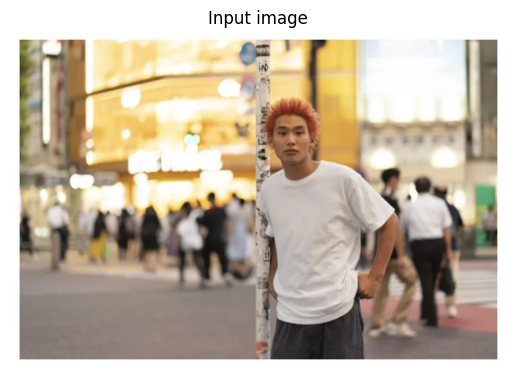


image 1/1 /home/rimsha/Desktop/360 projects/image-computer-vision/image-computer-vision-python/images/person1.png: 448x640 14 persons, 1 handbag, 73.4ms
Speed: 2.1ms preprocess, 73.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


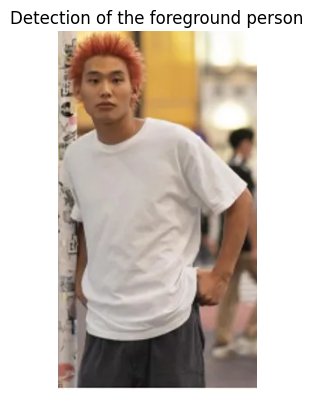

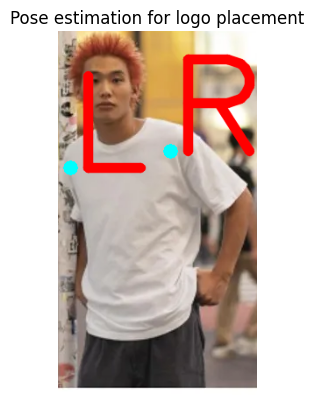

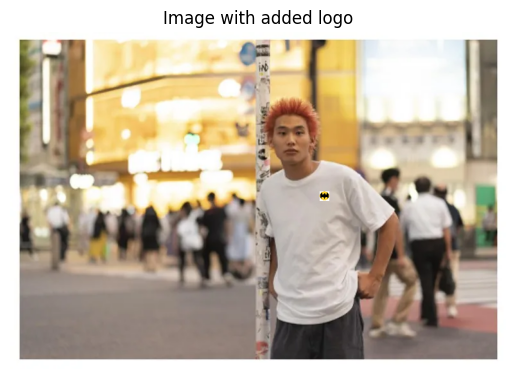

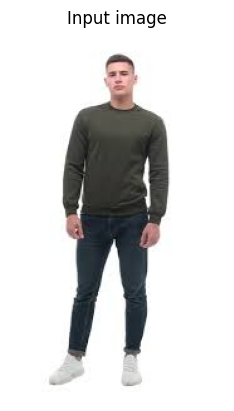


image 1/1 /home/rimsha/Desktop/360 projects/image-computer-vision/image-computer-vision-python/images/person2.png: 640x384 1 person, 63.3ms
Speed: 1.8ms preprocess, 63.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)


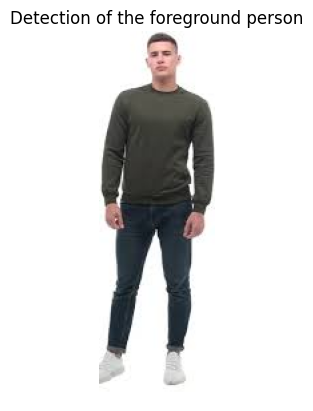

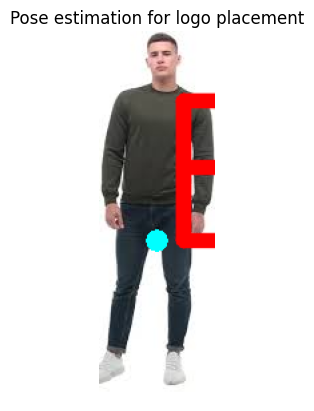

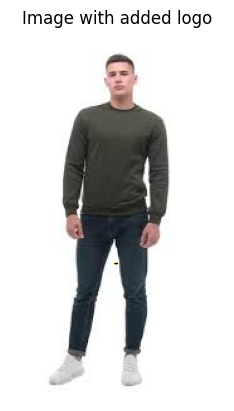

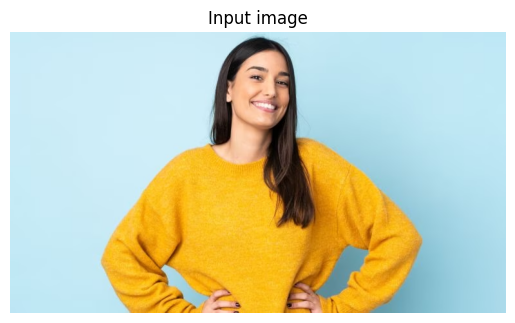


image 1/1 /home/rimsha/Desktop/360 projects/image-computer-vision/image-computer-vision-python/images/person3.png: 384x640 1 person, 64.2ms
Speed: 1.1ms preprocess, 64.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


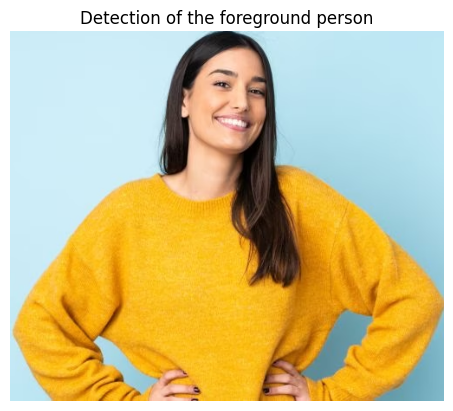

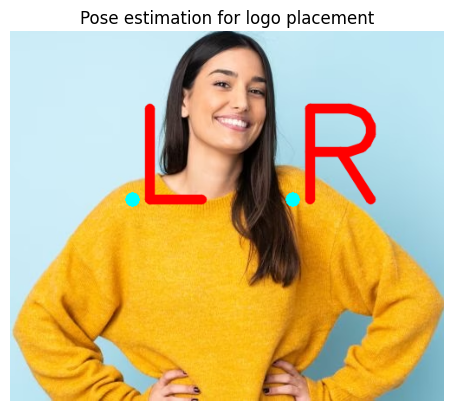

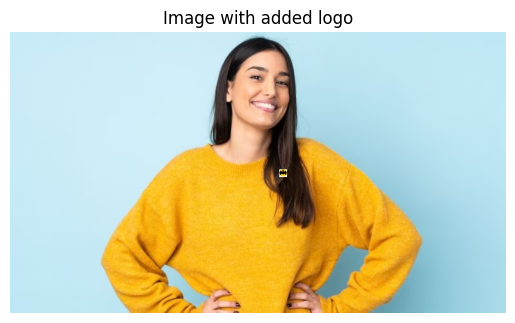

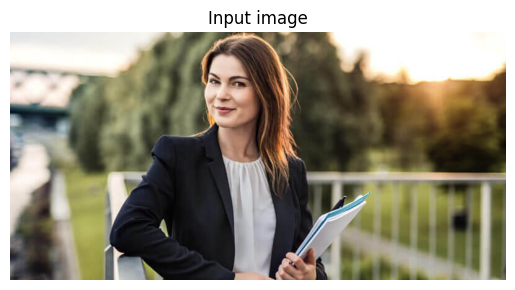


image 1/1 /home/rimsha/Desktop/360 projects/image-computer-vision/image-computer-vision-python/images/person4.png: 320x640 1 person, 1 frisbee, 1 tennis racket, 62.5ms
Speed: 1.8ms preprocess, 62.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


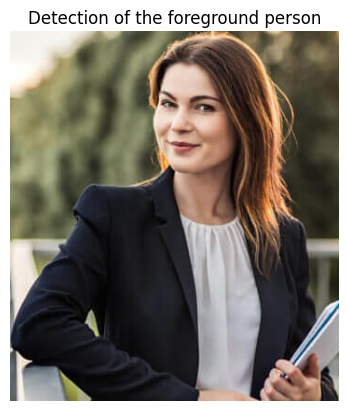

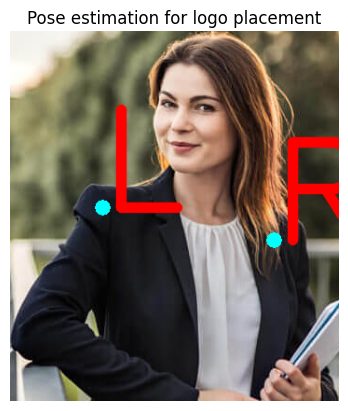

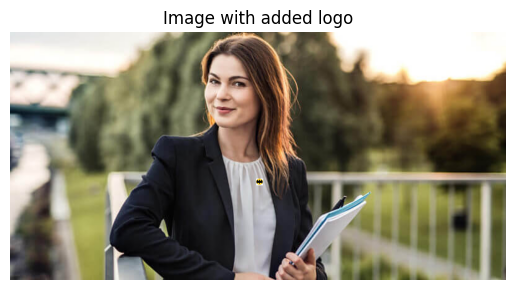

In [16]:
# Predict with the model
for img_idx in range(1, 5):
    image_name = f'images/person{img_idx}.png'
    perform_logo_placement(image_name)
    